In [2]:
# Core data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Spatial clustering and distance structures
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial import cKDTree

# Network analysis
import networkx as nx
from networkx.algorithms import community

# Utilities
from collections import defaultdict
from tqdm.auto import tqdm

# Analyze trend over time
from scipy.stats import linregress

# Import configuration
import constants
from pathlib import Path


# Blackpoll Warbler migration – data preparation

In this section, we load the eBird sample for Blackpoll Warbler, clean basic issues
(missing values, inconsistent observation counts), and restrict the data to a recent
time window. The goal is to obtain a clean observation-level dataset that is ready
for spatial clustering and subsequent network construction.


In [3]:
from pathlib import Path

folder = Path("/Users/ninasavas/Desktop/Network_Science/data/ebd_bkpwar_smp_relOct-2025")
print("folder exists:", folder.exists())


folder exists: True


In [4]:
# File path for Blackpoll Warbler observations
BASE_DIR = Path.cwd()
BKPWAR_PATH = BASE_DIR / constants.BKPWAR_PATH
# Load dataset
df_bkpwar = pd.read_csv(
    BKPWAR_PATH,
    sep="\t",
    usecols=constants.BIRD_COLS,
    low_memory=False,
)

# Null check
print("Null values df_bkpwar:\n", df_bkpwar.isna().sum())


Null values df_bkpwar:
 GLOBAL UNIQUE IDENTIFIER        0
COMMON NAME                     0
OBSERVATION COUNT               0
COUNTRY                         0
STATE                           0
COUNTY                      41795
LOCALITY                        0
LATITUDE                        1
LONGITUDE                       1
OBSERVATION DATE                1
dtype: int64


In [5]:
df_bkpwar["OBSERVATION DATE"] = pd.to_datetime(df_bkpwar["OBSERVATION DATE"])
df_bkpwar = df_bkpwar.sort_values(by="OBSERVATION DATE", ascending=False).reset_index(drop=True)

In [6]:
df_bkpwar.head(2)

,GLOBAL UNIQUE IDENTIFIER,COMMON NAME,OBSERVATION COUNT,COUNTRY,STATE,COUNTY,LOCALITY,LATITUDE,LONGITUDE,OBSERVATION DATE
0,URN:CornellLabOfOrnithology:EBIRD:OBS3713391932,Blackpoll Warbler,1,Venezuela,Miranda,NaN,Marquesal,10.494748,-66.804030,2025-10-31
1,URN:CornellLabOfOrnithology:EBIRD:OBS3714532106,Blackpoll Warbler,2,Guadeloupe,Guadeloupe,NaN,Chemin des Lataniers (La Désirade),16.299182,-61.095336,2025-10-31


In [7]:
#dropping COUNTY column
df_bkpwar.drop(columns=["COUNTY"], inplace=True)
#Drops all rows with null value in any column
df_bkpwar.dropna(inplace=True)

In [8]:
# Replacing "X" (unknown positive count) of observation with 1 and converting to integer
df_bkpwar["OBSERVATION COUNT"] = (
    df_bkpwar["OBSERVATION COUNT"]
    .replace("X", 1)
    .astype(int)
)

In [9]:
print("Total birds observed", df_bkpwar["OBSERVATION COUNT"].sum())

Total birds observed 2935819


## Time filtering: focus on recent decade

Migration patterns can change over long time scales. To focus on contemporary
behavior and reduce historical noise, we restrict the dataset to the most recent
10 years of observations. 


In [10]:
def filter_recent_years(df, years):
    """Return only observations from the most recent years"""
    max_date = df["OBSERVATION DATE"].max()
    cutoff_date = max_date - pd.DateOffset(years=years)
    return df[df["OBSERVATION DATE"] >= cutoff_date].copy()

df_bkpwar_recent = filter_recent_years(df_bkpwar, years=constants.YEARS_RECENT)

print(f"Data after filtering to recent decade: {len(df_bkpwar_recent):,} records")
print(
    f"Date range: {df_bkpwar_recent['OBSERVATION DATE'].min()} "
    f"to {df_bkpwar_recent['OBSERVATION DATE'].max()}"
)

Data after filtering to recent decade: 891,533 records
Date range: 2015-10-31 00:00:00 to 2025-10-31 00:00:00


# Spatial clustering: defining spatial nodes

To move from raw observations to a network representation, we first need to define
spatial regions that will act as nodes in the graph. We use density-based spatial
clustering (DBSCAN) on latitude/longitude coordinates to identify coherent spatial
clusters. Each observation will later be assigned to one of these clusters.

The function below implements a custom DBSCAN variant using a KD-tree for efficient
neighbor queries on large point sets.

In [11]:
def custom_dbscan_kdtree(points, eps, min_samples):
    """
    Custom DBSCAN implementation using a KD-tree for fast neighborhood queries.

    Parameters
    ----------
    points : ndarray of shape (n_points, n_dims)
        Input coordinates (e.g., latitude/longitude projected to km).
    eps : float
        Maximum distance for two points to be considered neighbors.
    min_samples : int
        Minimum number of points (including itself) required to form a core point.

    Returns
    -------
    labels : ndarray of shape (n_points,)
        Cluster labels for each point.
        -1 denotes noise.
    """

    from collections import deque
    import numpy as np
    from scipy.spatial import cKDTree

    # Build KD-tree for efficient epsilon-neighborhood queries
    tree = cKDTree(points)

    # Precompute neighbors for every point (epsilon-neighborhood graph)
    neighbors = tree.query_ball_point(points, eps, workers=-1)

    n_points = len(points)

    # Label conventions
    UNVISITED = -99
    NOISE = -1

    # Initialize all points as unvisited
    labels = np.full(n_points, UNVISITED, dtype=np.int32)

    current_cluster_id = 0

    # Iterate over all points
    for i in range(n_points):

        # Skip if already processed
        if labels[i] != UNVISITED:
            continue

        # If not a core point, mark as noise
        if len(neighbors[i]) < min_samples:
            labels[i] = NOISE
            continue

        # Start a new cluster
        labels[i] = current_cluster_id

        # Queue for breadth-first expansion (THIS FIXES THE 1-HOP ISSUE)
        queue = deque(neighbors[i])

        # Expand cluster via density connectivity
        while queue:
            j = queue.popleft()

            # If previously marked as noise, reassign as border point
            if labels[j] == NOISE:
                labels[j] = current_cluster_id

            # Skip if already assigned to a cluster
            if labels[j] != UNVISITED:
                continue

            # Assign point j to the current cluster
            labels[j] = current_cluster_id

            # If j is a core point, expand further from it
            if len(neighbors[j]) >= min_samples:
                for n in neighbors[j]:
                    if labels[n] in (UNVISITED, NOISE):
                        queue.append(n)

        # Move to the next cluster
        current_cluster_id += 1

    return labels


## Aggregating very close observations

Many eBird observations are extremely close in space. Before running DBSCAN, we group observations into small
latitude/longitude grid cells (~1.1 km at 0.01 degrees). Within each grid cell we:

- Average the coordinates to obtain a single representative point.
- Sum observation counts to keep track of total birds.
- Keep the most common state label.

This reduces noise and speeds up clustering without changing the large-scale
spatial structure of the data.


Fixed the previous code  with recursive neighborhood expansion using a queue, ensuring clusters reflect full density connectivity rather than only immediate neighbors.

In [12]:
def aggregate_close_observations(obs_df, precision_deg=0.01):
    """
    Group observations that fall into the same small lat/lon grid cell.

    precision_deg controls the grid size (0.01 degrees ≈ 1.1 km).
    """
    df = obs_df.copy()

    # Snap coordinates to a regular grid
    df["lat_rounded"] = (df["LATITUDE"] / precision_deg).round() * precision_deg
    df["lon_rounded"] = (df["LONGITUDE"] / precision_deg).round() * precision_deg

    # Aggregate all observations in the same grid cell
    agg_df = (
        df.groupby(["lat_rounded", "lon_rounded"])
          .agg({
              "LATITUDE": "mean",
              "LONGITUDE": "mean",
              "OBSERVATION COUNT": "sum",
              "STATE": lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown",
          })
          .reset_index()
    )

    print(
        f"Grid aggregation: {len(obs_df):,} observations → "
        f"{len(agg_df):,} grid points"
    )
    return agg_df

## Clustering aggregated points in space

After grid aggregation, we cluster the resulting points using the custom DBSCAN
implementation. The main parameters are:

- `eps_km`: neighborhood radius in kilometers (here, default 25 km).
- `min_samples`: minimum number of nearby points required to form a dense region.

The output of this step is a set of spatial clusters, each identified by a
`cluster_id`. These clusters represent candidate spatial nodes for the migration
network, but we still need to map each original observation to its nearest cluster.


In [13]:
def cluster_aggregated_points(agg_points_df, eps_km=25, min_samples=3):
    """
    Run custom DBSCAN on the aggregated grid points. (non-batched version)

    Returns
    -------
    clustered_points_df : pd.DataFrame
        Copy of agg_points_df with a 'cluster_id' column.
    eps_deg : float
        Neighborhood radius in degrees, used later for distance checks.
    """
    clustered_points_df = agg_points_df.copy()

    # Coordinates used for clustering
    coords = clustered_points_df[["LATITUDE", "LONGITUDE"]].values

    # Convert neighborhood radius from kilometers to degrees (roughly)
    eps_deg = eps_km / 111.0  # 1 degree ≈ 111 km on Earth

    print(
        f"Clustering {len(clustered_points_df):,} grid points "
        f"with eps ≈ {eps_km} km (≈ {eps_deg:.4f} degrees), "
        f"min_samples = {min_samples}..."
    )

    # For now, cluster everything at once (fine for moderate sizes)
    labels = custom_dbscan_kdtree(coords, eps_deg, min_samples)
    clustered_points_df["cluster_id"] = labels

    # You can later plug in your batched logic here if needed for very large data
    return clustered_points_df, eps_deg


## Assigning observations to spatial clusters

Once DBSCAN has identified spatial clusters, we assign each original observation
to its nearest cluster centroid. This gives every observation a `cluster_id` that
tells us which spatial region it belongs to.

Observations that are too far away from all cluster centroids (relative to the
chosen `eps_km`) are treated as noise and assigned `cluster_id = -1`. These can
be excluded from the network or handled separately if needed.


In [14]:
def assign_observations_to_clusters(obs_df, clustered_points_df, eps_deg):
    """
    For each observation, find the nearest cluster centroid and assign its cluster_id.

    Observations farther than 2 * eps_deg away from any centroid are marked as noise (-1).

    Returns
    -------
    obs_with_clusters : copy of obs_df with an added 'cluster_id' column.
    """

    # Keep only valid clusters (ignore DBSCAN noise)
    valid_clusters = clustered_points_df[clustered_points_df["cluster_id"] != -1]
    cluster_ids_array = valid_clusters["cluster_id"].values

    # Store original observation coordinates
    obs_with_clusters = obs_df.copy()
    obs_coords = obs_with_clusters[["LATITUDE", "LONGITUDE"]].values

    # Build a KD-tree over cluster centroids
    cluster_coords = valid_clusters[["LATITUDE", "LONGITUDE"]].values
    cluster_tree = cKDTree(cluster_coords)

    # For each observation, find the index of the nearest cluster centroid
    distances, nearest_idx = cluster_tree.query(obs_coords, k=1, workers=-1)

    obs_with_clusters["cluster_id"] = cluster_ids_array[nearest_idx]

    # Observations too far from every cluster centroid are treated as noise
    max_dist_deg = eps_deg * 2.0  # small buffer above eps
    obs_with_clusters.loc[distances > max_dist_deg, "cluster_id"] = -1

    return obs_with_clusters


## Building a cluster-level node table

To analyze the migration network, we need a node table describing each spatial
cluster. For every `cluster_id`, we compute:

- A weighted centroid position.
- The number of observations and total birds.
- The first and last observation dates within the cluster.
- A dominant state label.
- A rough area estimate.


In [15]:
def build_cluster_node_table(obs_with_clusters, eps_km=25):
    """
    Summarize each spatial cluster as a node with spatial and temporal attributes.

    Returns
    -------
    cluster_nodes_df : One row per cluster_id with centroid, counts, and time range.
    """
    cluster_records = []

    for cid in np.unique(obs_with_clusters["cluster_id"]):
        if cid == -1:
            continue  # skip noise

        # Get all observations in this cluster
        cluster_obs = obs_with_clusters[obs_with_clusters["cluster_id"] == cid]

        # Compute a centroid; use observation counts as weights
        weights = cluster_obs["OBSERVATION COUNT"].fillna(1).values
        centroid_lat = np.average(cluster_obs["LATITUDE"].values, weights=weights)
        centroid_lon = np.average(cluster_obs["LONGITUDE"].values, weights=weights)

        cluster_records.append({
            "cluster_id": int(cid),
            "centroid_lat": centroid_lat,
            "centroid_lon": centroid_lon,
            "n_observations": len(cluster_obs),
            "total_birds": cluster_obs["OBSERVATION COUNT"].sum(),
            "first_seen": cluster_obs["OBSERVATION DATE"].min(),
            "last_seen": cluster_obs["OBSERVATION DATE"].max(),
            "state": (
                cluster_obs["STATE"].mode().iloc[0]
                if not cluster_obs["STATE"].mode().empty
                else "Unknown"
            )
        })

    cluster_nodes_df = pd.DataFrame(cluster_records)
    print(f"Cluster summary: {len(cluster_nodes_df)} clusters")
    return cluster_nodes_df


# From observations to spatial nodes

The helper functions above are combined into a small pipeline. Starting from the
cleaned and time-filtered Blackpoll Warbler observations, the pipeline:

1. Aggregates very close observations into grid cells.
2. Clusters the grid points using DBSCAN to obtain spatial clusters.
3. Assigns each original observation to its nearest cluster.
4. Builds a node table summarizing each cluster.

This produces two key objects:

- `df_bkpwar_clusters`: observation-level data, where each observation carries
  a `cluster_id` and a timestamp.
- `nodes_bkpwar`: node table (one row per spatial cluster) for network analysis.


In [16]:
def run_spatial_clustering_pipeline(obs_df, eps_km=25, min_samples=3):
    """
    From cleaned bird observations to:
      1) observations with cluster_id,
      2) cluster node table suitable for network analysis.
    """
    # 1) Group very nearby points to reduce noise and size
    agg_points_df = aggregate_close_observations(obs_df)

    # 2) Cluster the aggregated points in space
    clustered_points_df, eps_deg = cluster_aggregated_points(
        agg_points_df,
        eps_km=eps_km,
        min_samples=min_samples,
    )

    # 3) Assign each original observation to its nearest cluster
    obs_with_clusters = assign_observations_to_clusters(
        obs_df,
        clustered_points_df,
        eps_deg,
    )

    # 4) Create a node table (one row per cluster)
    cluster_nodes_df = build_cluster_node_table(
        obs_with_clusters,
        eps_km=eps_km,
    )

    return obs_with_clusters, cluster_nodes_df


In [17]:
df_bkpwar_clusters, nodes_bkpwar = run_spatial_clustering_pipeline(df_bkpwar_recent,eps_km=constants.EPS_KM,min_samples=constants.MIN_SAMPLES,)

Grid aggregation: 891,533 observations → 94,905 grid points
Clustering 94,905 grid points with eps ≈ 25 km (≈ 0.2252 degrees), min_samples = 3...
Cluster summary: 816 clusters


In [18]:
# Quick sanity checks
print(df_bkpwar_clusters[["LATITUDE", "LONGITUDE", "OBSERVATION DATE", "cluster_id"]].head())
print(nodes_bkpwar.head(2))

    LATITUDE  LONGITUDE OBSERVATION DATE  cluster_id
0  10.494748 -66.804030       2025-10-31          99
1  16.299182 -61.095336       2025-10-31         126
2  16.299182 -61.095336       2025-10-31         126
3  41.735262 -70.384769       2025-10-31         223
4  16.299984 -61.094594       2025-10-31         126
   cluster_id  centroid_lat  centroid_lon  n_observations  total_birds  \
0           0    -23.796707    -46.527789              25           26   
1           1     -6.640542    -76.298839              11           11   

  first_seen  last_seen       state  
0 2019-12-09 2024-01-30   São Paulo  
1 2017-02-10 2024-12-05  San Martín  


# Edge Creation

## Methodological Considerations

An initial approach based on individual bird trajectories resulted in graphs
where each node had in-degree and out-degree at most one, forming simple path
structures. In such graphs, most network science measures (e.g., clustering
coefficient, community detection) are not meaningful.

Recognizing this limitation, we reformulated the network to represent aggregated
flows between clusters across time. This shift transforms the graph into a
true network with heterogeneous degree distributions, allowing for meaningful
application of network science concepts.


In [19]:
# -----------------------------
# Temporal columns
# -----------------------------
df_bkpwar_clusters["year"] = df_bkpwar_clusters["OBSERVATION DATE"].dt.year
df_bkpwar_clusters["month"] = df_bkpwar_clusters["OBSERVATION DATE"].dt.month

graphs_by_year = {}

# -----------------------------
# Build networks year by year
# -----------------------------
for year, year_df in tqdm(
    df_bkpwar_clusters.groupby("year"),
    desc="Building yearly temporal networks"
):
    year_df = year_df.sort_values("OBSERVATION DATE")

    # ---- Active clusters this year ----
    active_clusters = set(year_df["cluster_id"].unique())

    # ---- Initialize graph ----
    G = nx.DiGraph(year=year)

    # ---- Add only ACTIVE nodes with attributes ----
    nodes_year = nodes_bkpwar[nodes_bkpwar["cluster_id"].isin(active_clusters)]

    for _, row in nodes_year.iterrows():
        node_id = row["cluster_id"]
        attrs = row.drop("cluster_id").to_dict()
        G.add_node(node_id, **attrs)

    # ---- Group observations by month ----
    monthly_groups = year_df.groupby("month", sort=True)
    months = list(monthly_groups.groups.keys())

    edge_weights = defaultdict(float)

    for i in range(len(months) - 1):
        m_t = months[i]
        m_t1 = months[i + 1]

        # skip gaps
        if m_t1 != m_t + 1:
            continue

        df_t = monthly_groups.get_group(m_t)
        df_t1 = monthly_groups.get_group(m_t1)

        counts_t = df_t.groupby("cluster_id")["OBSERVATION COUNT"].sum()
        counts_t1 = df_t1.groupby("cluster_id")["OBSERVATION COUNT"].sum()

        total_t1 = counts_t1.sum()

        for u, c_u in counts_t.items():
            candidates = []

            for v, c_v in counts_t1.items():
                w = c_v / total_t1  # normalized by destination month
                candidates.append((v, w))

            if not candidates:
                continue

            candidates.sort(key=lambda x: x[1], reverse=True)
            max_w = candidates[0][1]

            kept = [(v, w) for v, w in candidates if w >= constants.MIN_FRAC * max_w]

            if len(kept) < constants.K_EDGES:
                kept = candidates[:constants.K_EDGES]

            for v, w in kept:
                edge_weights[(u, v)] += w

    # ---- Add edges ----
    for (u, v), w in edge_weights.items():
        if w > 0:
            G.add_edge(u, v, weight=w)

    # ---- Remove isolated nodes ----
    G.remove_nodes_from(list(nx.isolates(G)))

    graphs_by_year[year] = G


Building yearly temporal networks:   0%|          | 0/11 [00:00<?, ?it/s]

In [29]:
for year, G in graphs_by_year.items():
    degrees = dict(G.degree())
    strengths = dict(G.degree(weight="weight"))

    print(
        f"Year {year}:",
        f"nodes={G.number_of_nodes()}",
        f"edges={G.number_of_edges()}",
        f"max_degree={max(degrees.values()) if degrees else 0}"
    )

Year 2016: nodes=368 edges=5540 max_degree=400
Year 2017: nodes=422 edges=6571 max_degree=463
Year 2018: nodes=459 edges=7129 max_degree=492
Year 2019: nodes=473 edges=7235 max_degree=499
Year 2020: nodes=473 edges=7300 max_degree=500
Year 2021: nodes=511 edges=7941 max_degree=541
Year 2022: nodes=535 edges=8520 max_degree=571
Year 2023: nodes=553 edges=8853 max_degree=568
Year 2024: nodes=527 edges=8423 max_degree=561


We restrict our analysis to the period 2016–2024. The year 2015 was excluded due to insufficient spatial coverage, and 2025 was excluded as it represents a partial year with incomplete migration data. This ensures comparability of network structure across years.

Full spatial "pool": 816 clusters (all time)

Yearly active clusters: 368–553 (2016–2024)

Percent active per year: (368/816) to (553/816) = 45–68%


In [21]:
for y in [2015, 2025]:
    graphs_by_year.pop(y, None)

In [22]:
df_bkpwar_clusters = df_bkpwar_clusters[
    df_bkpwar_clusters["year"].between(2016, 2024)
]

In [23]:
print(sorted(df_bkpwar_clusters["year"].unique()))

[np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]


## Network Analysis

In [24]:
summary = []
for year in sorted(graphs_by_year):
    G = graphs_by_year[year]
    deg = np.array([d for _, d in G.degree()])
    strw = np.array([s for _, s in G.degree(weight="weight")])

    if deg.size:
        dp = np.percentile(deg, [50, 75, 90, 99])
    else:
        dp = [np.nan] * 4

    if strw.size:
        sp = np.percentile(strw, [50, 75, 90, 99])
    else:
        sp = [np.nan] * 4

    summary.append({
        "year": year,
        "deg_p50": dp[0], "deg_p75": dp[1], "deg_p90": dp[2], "deg_p99": dp[3],
        "str_p50": sp[0], "str_p75": sp[1], "str_p90": sp[2], "str_p99": sp[3],
    })

percentiles_df = pd.DataFrame(summary).sort_values("year").reset_index(drop=True)
display(percentiles_df)

,year,deg_p50,deg_p75,deg_p90,deg_p99,str_p50,str_p75,str_p90,str_p99
0,2016,12.0,20.0,69.6,301.94,1.296104,2.291090,3.801841,29.325347
1,2017,10.0,20.0,67.0,319.00,0.962015,1.856674,4.245109,32.177852
2,2018,10.0,21.0,56.0,341.26,0.988240,2.600903,3.708012,26.728709
3,2019,10.0,20.0,42.0,376.20,0.928349,2.587225,3.850045,22.397305
4,2020,10.0,18.0,47.4,371.00,0.989397,1.943566,3.867599,21.213080
5,2021,10.0,19.0,43.0,391.60,0.980507,2.665990,3.800495,25.629058
6,2022,13.0,19.0,44.6,408.30,1.710618,1.926772,3.785574,31.073703
7,2023,13.0,20.0,45.0,427.32,0.984840,2.144768,3.759124,32.134557
8,2024,13.0,19.0,52.0,391.70,1.636466,2.586606,4.435994,38.193165


From 2016 → 2024,

Most birds funnel through fewer, more critical routes

Super-hubs (99th percentile degree) become MORE connected (+90 degree 2016-2024)
Super-hub traffic intensifies (+9 strength 2016-2024)

## Community Detection

In [25]:
community_results = []

for year, G in sorted(graphs_by_year.items()):
    # Convert to undirected for community detection
    G_undirected = G.to_undirected()
    
    # Detect communities using greedy modularity optimization
    communities = community.greedy_modularity_communities(G_undirected, weight='weight')
    
    # Compute modularity score
    modularity = community.modularity(G_undirected, communities, weight='weight')
    
    # Compute community sizes
    community_sizes = sorted([len(c) for c in communities], reverse=True)
    
    community_results.append({
        'year': year,
        'num_communities': len(communities),
        'modularity': modularity,
        'largest_community_size': community_sizes[0] if community_sizes else 0,
        'community_sizes': community_sizes
    })
    
    print(f"{year}: {len(communities)} communities, modularity={modularity:.3f}, "
          f"sizes={community_sizes}")

# Create DataFrame for trend analysis
community_df = pd.DataFrame(community_results)
display(community_df[['year', 'num_communities', 'modularity', 'largest_community_size']])

# ========== Trend analysis: Are corridors fragmenting? ==========
slope_comm, intercept_comm, r_value_comm, p_value_comm, std_err_comm = linregress(
    community_df['year'], 
    community_df['num_communities']
)

slope_mod, intercept_mod, r_value_mod, p_value_mod, std_err_mod = linregress(
    community_df['year'], 
    community_df['modularity']
)

2016: 3 communities, modularity=0.245, sizes=[163, 120, 85]
2017: 2 communities, modularity=0.231, sizes=[302, 120]
2018: 3 communities, modularity=0.231, sizes=[191, 170, 98]
2019: 2 communities, modularity=0.226, sizes=[351, 122]
2020: 2 communities, modularity=0.191, sizes=[372, 101]
2021: 3 communities, modularity=0.227, sizes=[212, 183, 116]
2022: 3 communities, modularity=0.262, sizes=[209, 204, 122]
2023: 3 communities, modularity=0.264, sizes=[219, 197, 137]
2024: 3 communities, modularity=0.287, sizes=[197, 190, 140]


,year,num_communities,modularity,largest_community_size
0,2016,3,0.245261,163
1,2017,2,0.230777,302
2,2018,3,0.231015,191
3,2019,2,0.225678,351
4,2020,2,0.190929,372
5,2021,3,0.227026,212
6,2022,3,0.261779,209
7,2023,3,0.264425,219
8,2024,3,0.287002,197


No significant trend in the number of communities

In [26]:
for year in [2016, 2020, 2024]:
    
    G = graphs_by_year[year]
    G_undirected = G.to_undirected()
    communities = community.greedy_modularity_communities(G_undirected, weight='weight')
    
    print("\n" + "=" * 70)
    print(f"\nYear {year}: {len(communities)} communities")
    
    for i, comm in enumerate(communities, 1):
        # Get spatial info about this community
        comm_nodes = list(comm)
        comm_lats = nodes_bkpwar[nodes_bkpwar['cluster_id'].isin(comm_nodes)]['centroid_lat']
        comm_lons = nodes_bkpwar[nodes_bkpwar['cluster_id'].isin(comm_nodes)]['centroid_lon']
        
        if len(comm_lats) > 0:
            print(f"\n  Community {i}: {len(comm)} clusters")
            print(f"    Latitude range: {comm_lats.min():.2f}°N to {comm_lats.max():.2f}°N")
            print(f"    Longitude range: {comm_lons.min():.2f}°W to {comm_lons.max():.2f}°W")
            print(f"    Center: ({comm_lats.mean():.2f}°N, {comm_lons.mean():.2f}°W)")
            
            # Get dominant states in community
            states_in_comm = nodes_bkpwar[nodes_bkpwar['cluster_id'].isin(comm_nodes)]['state'].value_counts()
            print(f"    Top states: {', '.join(states_in_comm.head(3).index.tolist())}")



Year 2016: 3 communities

  Community 1: 163 clusters
    Latitude range: 19.32°N to 66.24°N
    Longitude range: -164.98°W to -53.27°W
    Center: (50.32°N, -109.98°W)
    Top states: Alaska, Yukon Territory, Quebec

  Community 2: 120 clusters
    Latitude range: 8.38°N to 64.82°N
    Longitude range: -147.65°W to -56.19°W
    Center: (41.54°N, -94.44°W)
    Top states: Alberta, North Dakota, Texas

  Community 3: 85 clusters
    Latitude range: -6.03°N to 46.82°N
    Longitude range: -123.00°W to -52.29°W
    Center: (14.32°N, -77.01°W)
    Top states: California, Meta, Amazonas


Year 2020: 2 communities

  Community 1: 372 clusters
    Latitude range: 8.61°N to 65.29°N
    Longitude range: -161.65°W to -53.27°W
    Center: (43.77°N, -100.72°W)
    Top states: Alberta, North Dakota, Alaska

  Community 2: 101 clusters
    Latitude range: -23.80°N to 60.30°N
    Longitude range: -102.54°W to -1.34°W
    Center: (12.28°N, -70.64°W)
    Top states: Meta, Arauca, Falcón


Year 2024: 

### Geographic Pattern: What Changed 2016 → 2024?

1. Community 1 (Western corridor)

    Birds moving away from Alaska coast → toward interior Canada
    Could reflect: breeding range shift, changing stopover use

2. Community 2 (Central corridor)

    Classic climate signal: Migration moving northward
    Consistent with warming, earlier springs

3. Community 3 (Tropical corridor)

    Wintering range shifting west/south
    Birds abandoning Central America for northern South America

## Network Visualization and Analysis

In [27]:
def compute_edge_persistence(graphs_by_year):
    """How many edges appear in consecutive years?"""
    years = sorted(graphs_by_year.keys())
    persistence = []
    
    for i in range(len(years)-1):
        G1 = graphs_by_year[years[i]]
        G2 = graphs_by_year[years[i+1]]
        
        edges1 = set(G1.edges())
        edges2 = set(G2.edges())
        
        persistence.append({
            'year': years[i],
            'persistent_edges': len(edges1 & edges2),
            'total_edges': len(edges1 | edges2),
            'jaccard': len(edges1 & edges2) / len(edges1 | edges2)
        })
    
    return pd.DataFrame(persistence)

EDGE PERSISTENCE ANALYSIS: Year-to-Year Migration Route Stability


,year,persistent_edges,total_edges,jaccard
0,2016,2842,9269,0.306613
1,2017,3067,10633,0.288442
2,2018,3596,10768,0.333952
3,2019,3450,11085,0.311231
4,2020,3575,11666,0.306446
5,2021,3932,12529,0.313832
6,2022,4663,12710,0.366876
7,2023,4537,12739,0.356150



SUMMARY STATISTICS
Average Jaccard similarity: 0.323
Minimum Jaccard similarity: 0.288 (year 2017)
Maximum Jaccard similarity: 0.367 (year 2022)

Average persistent edges: 3707.8
Average edge turnover: 67.7%


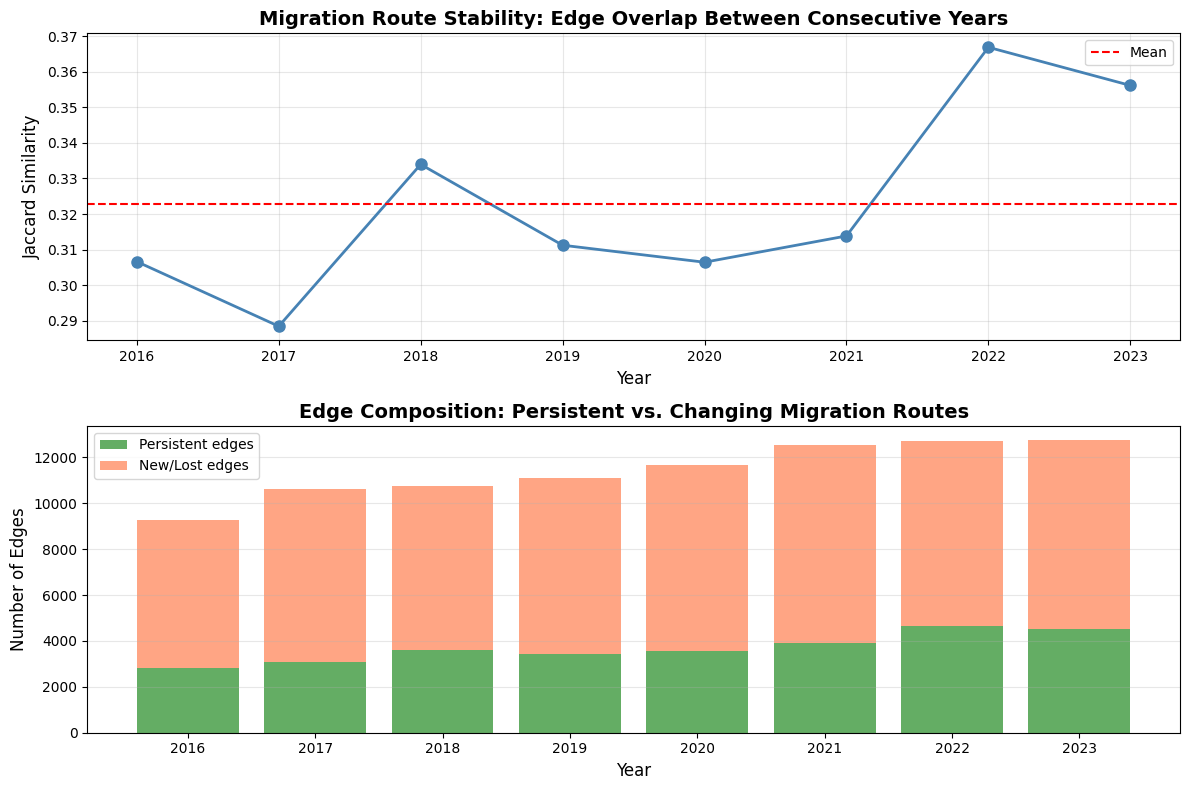

In [28]:
# Run the edge persistence analysis
persistence_df = compute_edge_persistence(graphs_by_year)

# Display the results
print("=" * 60)
print("EDGE PERSISTENCE ANALYSIS: Year-to-Year Migration Route Stability")
print("=" * 60)
display(persistence_df)

# Summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"Average Jaccard similarity: {persistence_df['jaccard'].mean():.3f}")
print(f"Minimum Jaccard similarity: {persistence_df['jaccard'].min():.3f} (year {persistence_df.loc[persistence_df['jaccard'].idxmin(), 'year']})")
print(f"Maximum Jaccard similarity: {persistence_df['jaccard'].max():.3f} (year {persistence_df.loc[persistence_df['jaccard'].idxmax(), 'year']})")
print(f"\nAverage persistent edges: {persistence_df['persistent_edges'].mean():.1f}")
print(f"Average edge turnover: {(1 - persistence_df['jaccard'].mean()) * 100:.1f}%")

# Visualize edge persistence over time
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Jaccard similarity over time
axes[0].plot(persistence_df['year'], persistence_df['jaccard'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(y=persistence_df['jaccard'].mean(), 
                color='red', linestyle='--', label='Mean')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Jaccard Similarity', fontsize=12)
axes[0].set_title('Migration Route Stability: Edge Overlap Between Consecutive Years', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Persistent vs New edges
persistence_df['new_or_lost_edges'] = persistence_df['total_edges'] - persistence_df['persistent_edges']

axes[1].bar(persistence_df['year'], persistence_df['persistent_edges'], 
            label='Persistent edges', color='forestgreen', alpha=0.7)
axes[1].bar(persistence_df['year'], persistence_df['new_or_lost_edges'], 
            bottom=persistence_df['persistent_edges'],
            label='New/Lost edges', color='coral', alpha=0.7)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Edges', fontsize=12)
axes[1].set_title('Edge Composition: Persistent vs. Changing Migration Routes', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Hubs are geographically stable (same regions year-to-year)
But connections between hubs are flexible (routes change)

## Node persistence

In [36]:
# Count years per node
node_years = defaultdict(set)

for year, G in graphs_by_year.items():
    for node in G.nodes():
        node_years[node].add(year)

node_persistence = pd.DataFrame({
    "cluster_id": list(node_years.keys()),
    "years_present": [len(yrs) for yrs in node_years.values()]
}).sort_values("years_present", ascending=False)

dist = (
    node_persistence["years_present"]
    .value_counts()
    .sort_index()
    .rename_axis("years_present")
    .to_frame("n_clusters")
)

dist["percent"] = 100 * dist["n_clusters"] / dist["n_clusters"].sum()
dist["cum_percent"] = dist["percent"].cumsum()

dist_display = dist.reset_index().style.format({
    "percent": "{:.2f}",
    "cum_percent": "{:.2f}"
})

display(dist_display)


,years_present,n_clusters,percent,cum_percent
0,1,58,7.14,7.14
1,2,87,10.71,17.86
2,3,125,15.39,33.25
3,4,88,10.84,44.09
4,5,65,8.00,52.09
5,6,92,11.33,63.42
6,7,58,7.14,70.57
7,8,72,8.87,79.43
8,9,167,20.57,100.00


Interpretation: counting how many clusters were seen in how many years

## Walk-based connectivity
Measuring indirect connectivity (structural properties, not behavioral trajectories)

In [37]:
walk_summary = []

for year, G in graphs_by_year.items():
    A = nx.to_numpy_array(G, weight="weight")
    n = A.shape[0]

    if n == 0:
        continue

    A2 = A @ A       # walks of length 2
    A3 = A2 @ A      # walks of length 3

    walk_summary.append({
        "year": year,
        "walk2_total": A2.sum() / n,
        "walk3_total": A3.sum() / n
    })

walk_df = pd.DataFrame(walk_summary).sort_values("year")
display(walk_df)


,year,walk2_total,walk3_total
0,2016,11.216583,69.221643
1,2017,10.283368,62.662696
2,2018,11.590440,75.763068
3,2019,10.801713,67.305540
4,2020,12.488447,85.753925
5,2021,11.429935,73.325842
6,2022,11.665515,76.486010
7,2023,11.272509,70.553239
8,2024,12.259187,82.326907


Interpretation: higher values → stronger indirect connectivity per region.

## Betweenness vs. in-strength comparison (node-level)

In [32]:
rows = []

for year, G in graphs_by_year.items():
    if G.number_of_nodes() == 0:
        continue

    betw = nx.betweenness_centrality(G, weight="weight", normalized=True)
    in_str = dict(G.in_degree(weight="weight"))

    for node in G.nodes():
        rows.append({
            "year": year,
            "cluster_id": node,
            "betweenness": betw.get(node, 0.0),
            "in_strength": in_str.get(node, 0.0)
        })

betw_vs_str = pd.DataFrame(rows)
display(betw_vs_str)


,year,cluster_id,betweenness,in_strength
0,2016,2,0.0,0.000000
1,2016,6,0.0,0.715328
2,2016,7,0.0,0.000000
3,2016,11,0.0,0.000000
4,2016,13,0.0,14.774576
...,...,...,...,...
4316,2024,808,0.0,0.000000
4317,2024,811,0.0,0.000000
4318,2024,812,0.0,0.000000
4319,2024,813,0.0,0.000000


## Weighted betweenness centrality (bottlenecks per year)

In [33]:
bottlenecks = []

for year, G in graphs_by_year.items():
    if G.number_of_nodes() < 3:
        continue

    betw = nx.betweenness_centrality(G, weight="weight", normalized=True)

    df_year = (
        pd.DataFrame({
            "cluster_id": list(betw.keys()),
            "betweenness": list(betw.values())
        })
        .assign(year=year)
        .sort_values("betweenness", ascending=False)
    )

    # keep top 5% as bottlenecks
    cutoff = df_year["betweenness"].quantile(0.95)
    bottlenecks.append(df_year[df_year["betweenness"] >= cutoff])

bottlenecks_df = pd.concat(bottlenecks, ignore_index=True)
display(bottlenecks_df)


,cluster_id,betweenness,year
0,191,0.059320,2016
1,16,0.047088,2016
2,486,0.033263,2016
3,744,0.015478,2016
4,307,0.011003,2016
...,...,...,...
216,61,0.000065,2024
217,463,0.000025,2024
218,186,0.000018,2024
219,727,0.000014,2024


Interpretation: regions whose removal would most disrupt migration connectivity